# PROJECT NAME : PRCP - 1001-RICE LEAF DISEASE DETECTION

# PROJECT TEAM ID : PTID-CDS-JUN-23-1549

# Team Members
* Arava. Yashodharani
* Carlene Blessy p 

#  1) Problem Statement

* Task 1:-Prepare a complete data analysis report on the given data.

* Task 2:-Create a model which can classify the three major attacking diseases of rice plants like leaf blast, bacterial blight and brown spot.

* Task3:- Analyze various techniques like Data Augmentation, etc and create a report on that.


# Business Statement


Rice is amongst the majorly cultivated crops in India and its leaf diseases can have a substantial impact on output and quality. The most important component is identifying rice leaf diseases, which have a direct impact on the economy and food security. Brown spot, Leaf Smut , Bacterial leaf blight are the most frequently occurring rice leaf diseases. To resolve this issue, we have studied various machine learning and deep learning approaches for detecting the diseases on their leaves by calculating their accuracy, recall, and precision to measure the performance. This study helps the farmers by detecting the diseases in rice leaves in order to get a healthy crop yield. The deep learning models perform well when compared with the machine learning methods. 



This dataset contains 120 jpg images of disease infected rice leaves.Based on these images we have to classify the dieases of rice leaf into three categories.

Classes:
- Leaf smut

- Brown spot

- Bacterial leaf blight

# 2) Load the libraries

In [53]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Input,Conv2D,MaxPooling2D,Flatten,Dropout,Dense
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img
from keras.preprocessing import image
from keras import regularizers
from tensorflow.keras import optimizers
import pathlib
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import models, layers
BATCH_SIZE = 12
IMAGE_SIZE = 256
CHANNELS = 3
EPOCHS = 50


# Constants

In [54]:
BATCH_SIZE = 12
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50

#  Load Image Dataset

In [55]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    r"E:\riceeeeeeeeeeee\PRCP-1001-RiceLeaf (1)\Data",
    seed=100,
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 119 files belonging to 3 classes.


# Types of Classes

In [56]:
class_names = dataset.class_names
class_names

['Bacterial leaf blight', 'Brown spot', 'Leaf smut']

* Here we can find the class names in the class_names attribute on these datasets.

# Dimension of image_batch, label_batch

In [57]:
for image_batch, labels_batch in dataset:
    print(image_batch.shape)
    print(labels_batch.numpy())
    break


(12, 256, 256, 3)
[0 2 1 2 2 2 1 0 1 0 2 0]


# Observation :
- The image_batch is a tensor of the shape (12, 256, 256, 3).
- This is a batch of 12 images of shape 256x256x3.
- the last dimension refers to color channels RGB.
   

# Data visualization

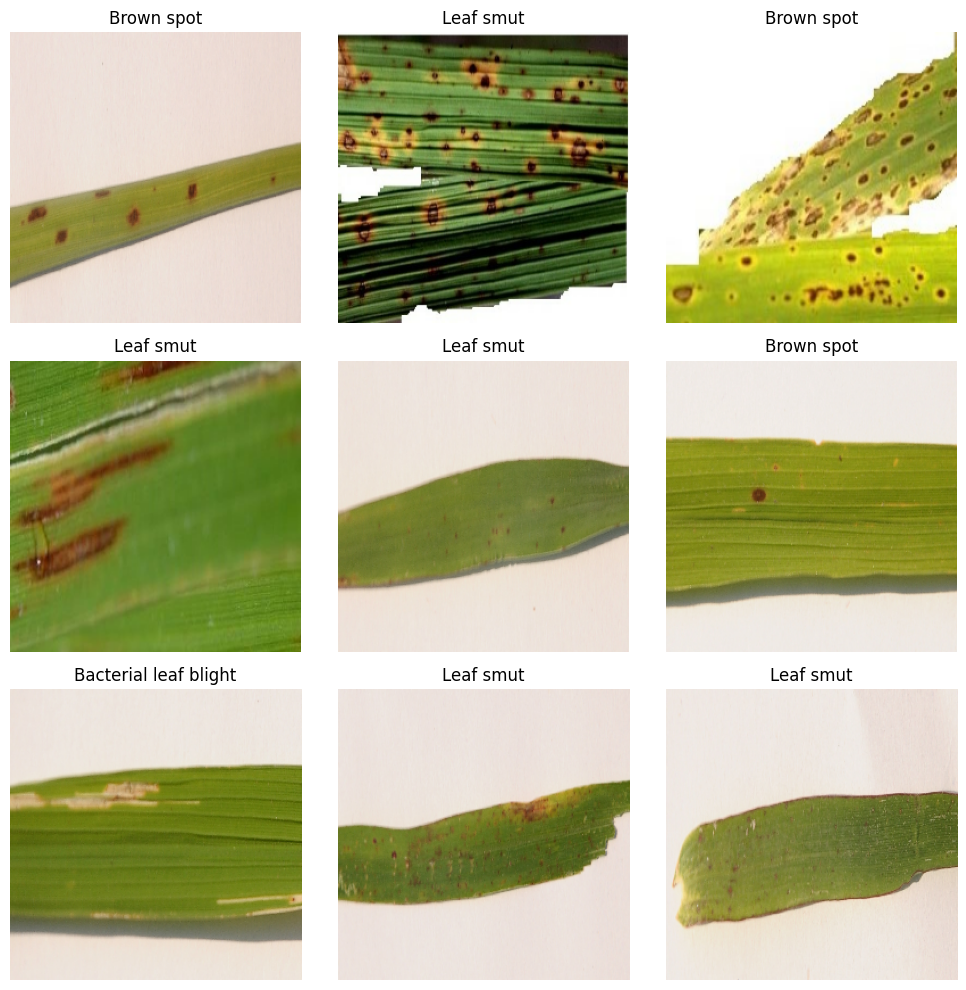

In [58]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
count = 0  # Number of images plotted
for images, labels in dataset:
    for i in range(len(images)):
        ax = plt.subplot(3, 3, count + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
        count += 1
        
        if count == 9:  # Break the loop after plotting 9 images
            break
    
    if count == 9:
        break

plt.tight_layout()
plt.show()



# Split Dataset into Categories: train, validation, test

In [59]:
len(dataset)

10

In [60]:
import tensorflow as tf

# Assuming dataset is your original dataset

# Splitting dataset into train and test sets
train_size = int(len(dataset) * 0.8)
test_size = int(len(dataset) * 0.1)
val_size = len(dataset) - train_size - test_size

train_ds = dataset.take(train_size)
test_ds = dataset.skip(train_size).take(test_size)
val_ds = dataset.skip(train_size + test_size)

# Printing the lengths of the resulting datasets
print(len(train_ds))
print(len(test_ds))
print(len(val_ds))


8
1
1


In [61]:
# function for spliting the dataset.

def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=100):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=100)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [62]:
# here, we split the dataset.

train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [63]:
len(train_ds)

8

In [64]:
len(val_ds)

1

In [65]:
len(test_ds)

1

## Resizing and Normalization

In [66]:
resize_and_rescale = tf.keras.Sequential([
    tf.keras.layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    tf.keras.layers.Rescaling(1.0/255),
])

## Data Augmentation


* It is a technique commonly used in computer vision tasks to artificially increase the size and diversity of the training dataset. By applying various transformations and modifications to the images, data augmentation helps the model generalize better and improve its ability to recognize and classify images.

In [67]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),
])

In [68]:
# Assuming train_ds is your original train dataset

# Define a function for data augmentation
def apply_data_augmentation(x, y):
    x = data_augmentation(x, training=True)
    return x, y

# Apply data augmentation using the map() method
train_ds = train_ds.map(apply_data_augmentation)

# Prefetch the dataset using the prefetch() method
train_ds = train_ds.prefetch(buffer_size=tf.data.AUTOTUNE)


#  Model Architecture

In [69]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

c:\Users\gsvsp\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [70]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_2 (Sequential)       │ (12, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (12, 254, 254, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (12, 127, 127, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (12, 125, 125, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (12, 62, 62, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (12, 60, 60, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (12, 30, 30, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (12, 28, 28, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (12, 14, 14, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (12, 12544)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (12, 64)               │       802,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (12, 3)                │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 896,323 (3.42 MB)

 Trainable params: 896,323 (3.42 MB)

 Non-trainable params: 0 (0.00 B)

# Compiling the Model
- we use **Adam** optimizer and **tf.keras.losses.SparseCategoricalCrossentropy** loss function. To view training and validation accuracy for each training epoch, pass the metrics argument to Model.compile.

In [71]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

# Training

In [72]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS,
)

Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 132ms/step - accuracy: 0.3579 - loss: 1.2453 - val_accuracy: 0.3333 - val_loss: 1.0927
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - accuracy: 0.3053 - loss: 1.1066 - val_accuracy: 0.4167 - val_loss: 1.0955
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - accuracy: 0.3368 - loss: 1.0973 - val_accuracy: 0.4167 - val_loss: 1.0879
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - accuracy: 0.4105 - loss: 1.0847 - val_accuracy: 0.4545 - val_loss: 1.0433
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 0.4316 - loss: 1.0684 - val_accuracy: 0.2500 - val_loss: 1.1503
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - accuracy: 0.4211 - loss: 1.0013 - val_accuracy: 0.7500 - val_loss: 0.9494
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step - accuracy: 0.4526 - loss: 1.0382 - val_accuracy: 0.3636 - val_loss: 1.1749
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 0.4271 - loss: 1.0441 - val_accuracy: 0.4167 - val_loss:

In [73]:
scores = model.evaluate(test_ds)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step - accuracy: 0.5833 - loss: 0.7501


In [74]:
model.evaluate(train_ds)

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step - accuracy: 0.8000 - loss: 0.4412


[0.44117671251296997, 0.800000011920929]

- We can see that the train accuracy is 83% and the test accuracy is 91%. It is clear that the model is good fitted.

# Plot training and validation graphs

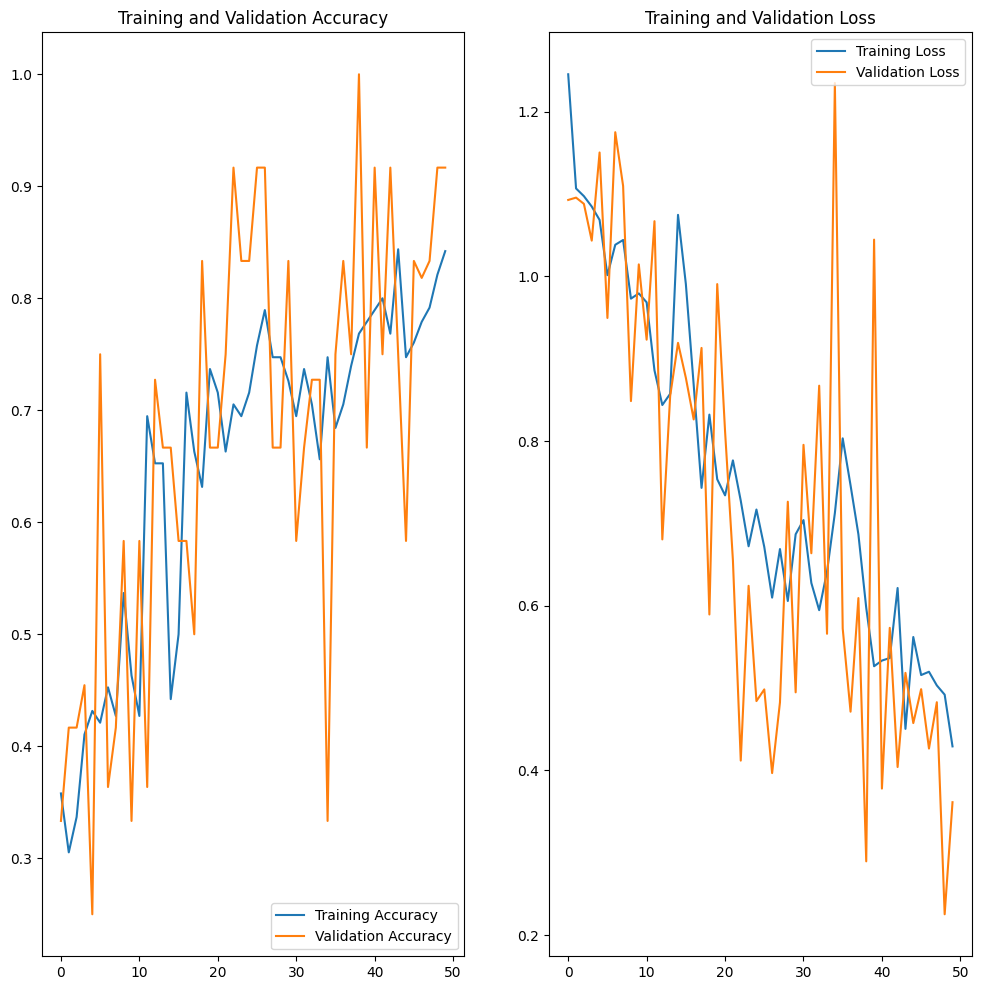

In [75]:

acc = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(12,12))
plt.subplot(1,2,1)
plt.plot(epochs_range,acc,label='Training Accuracy')
plt.plot(epochs_range,val_accuracy,label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(epochs_range,loss,label='Training Loss')
plt.plot(epochs_range,val_loss,label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Run prediction on a sample image

first image to predict
actual label: Bacterial leaf blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
predicted label: Bacterial leaf blight


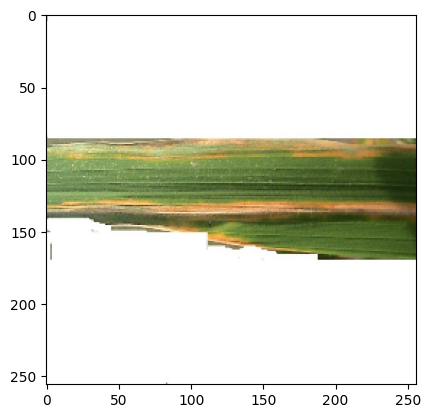

In [76]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])
    

First image to predict
Actual label: Leaf smut
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
Predicted label: Leaf smut


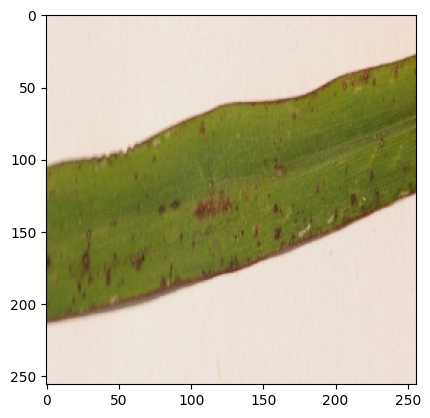

In [77]:
import numpy as np

for images_batch, labels_batch in test_ds:
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("First image to predict")
    plt.imshow(first_image)
    print("Actual label:", class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("Predicted label:", class_names[np.argmax(batch_prediction[0])])
    
    break  # Break the loop after processing the first batch


In [78]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


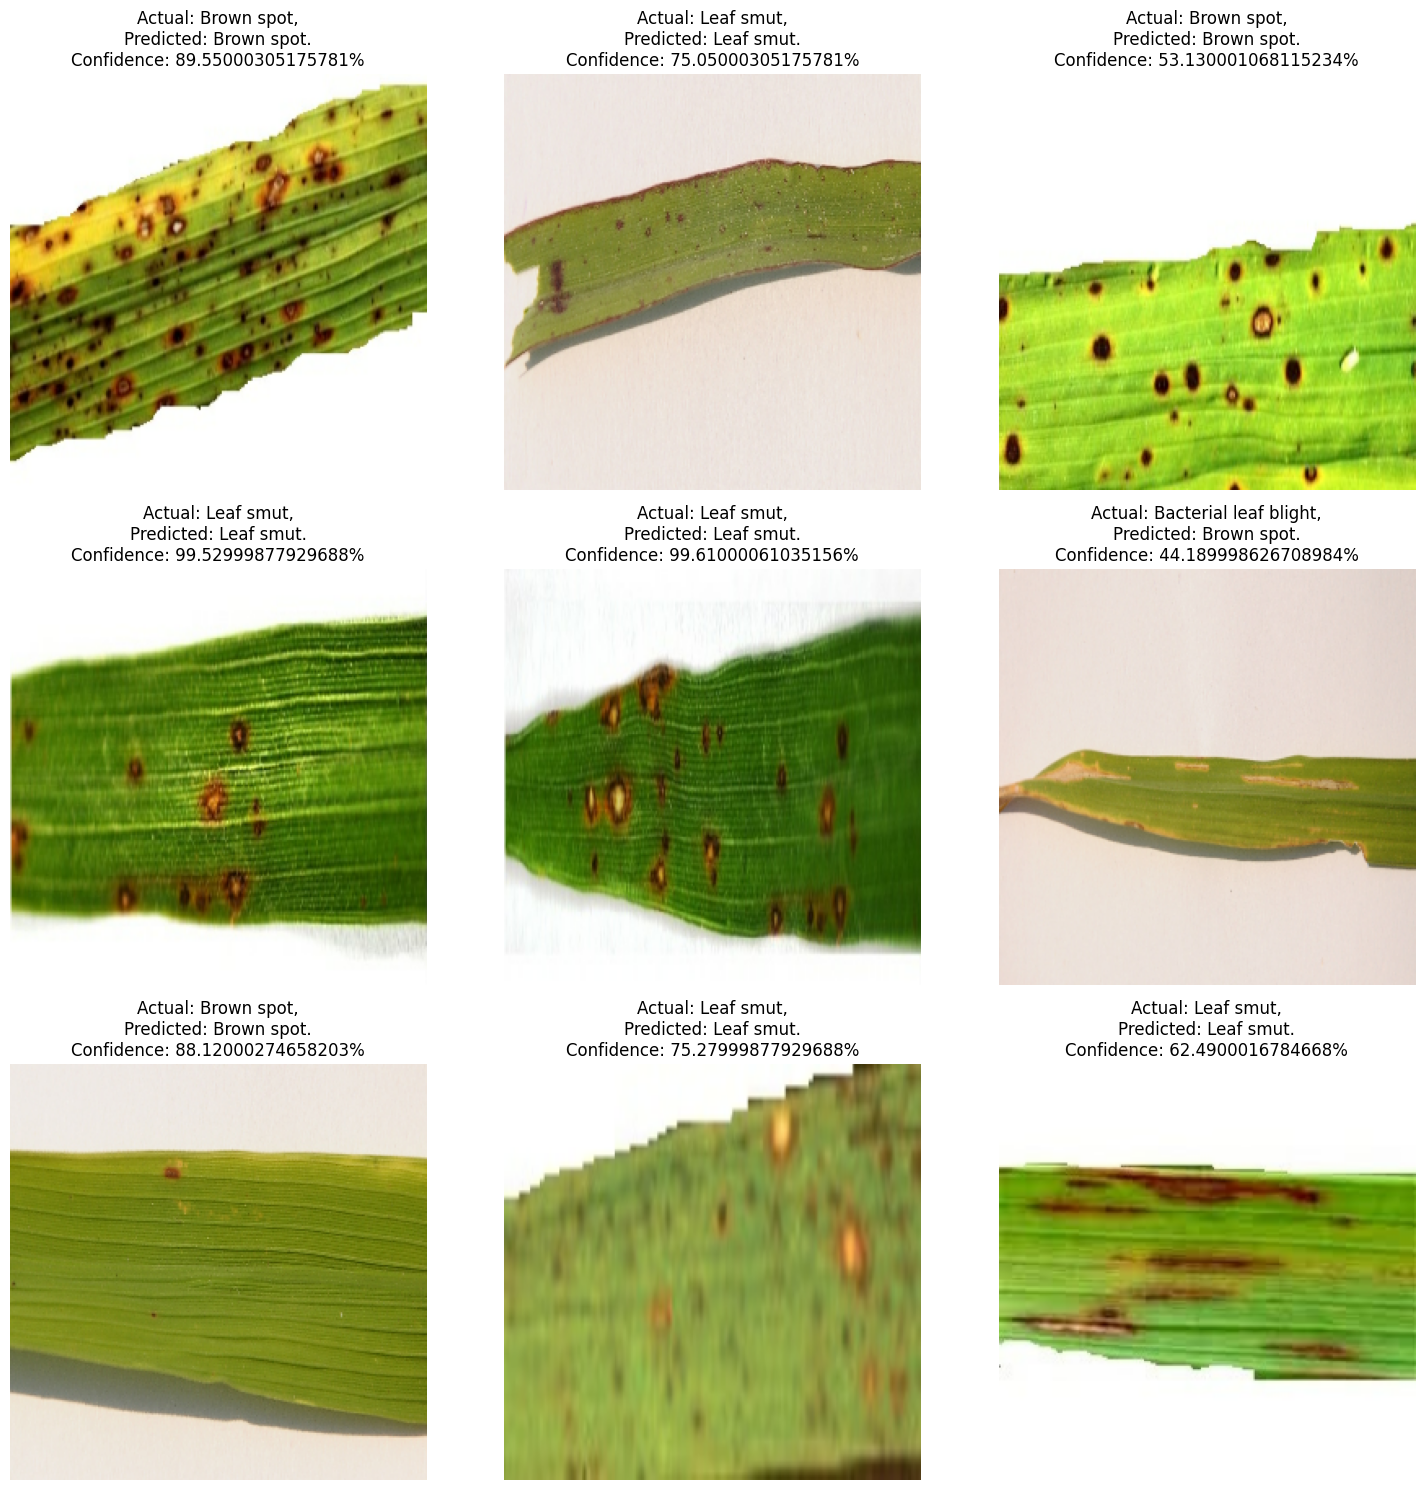

In [79]:
plt.figure(figsize=(15, 15))
count = 0  # Number of images plotted
for images, labels in test_ds:
    for i in range(len(images)):
        ax = plt.subplot(3, 3, count + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\nPredicted: {predicted_class}.\nConfidence: {confidence}%")

        plt.axis("off")
        count += 1

        if count == 9:  # Break the loop after plotting 9 images
            break

    if count == 9:
        break

plt.tight_layout()
plt.show()
